# Transfer Learing with Resnet-18 Model 

This project uses the pre-trained Resnet-18 models to classify between the negative and positive samples

<h2 id="download_data">Download Data</h2>


In [3]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2023-09-22 10:44:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip.1’

Positive_tensors.zi 100%[===================>]   2.42G  21.4MB/s    in 2m 1s   

2023-09-22 10:46:28 (20.4 MB/s) - ‘Positive_tensors.zip.1’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [4]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2023-09-22 10:46:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  30.9MB/s    in 69s     

2023-09-22 10:47:40 (29.1 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [1]:
!pip install torchvision

# Imports and Auxiliary Functions


In [2]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [3]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


## Data Class

In [4]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/wsuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [5]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


## Preparing a pre-trained resnet18 model 


Loading the pre-trained model <code>resnet18</code> and setting the parameter <code>pretrained</code> to true:


In [6]:
model = models.resnet18(pretrained = True)

/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Settig the attribute <code>requires_grad</code> to <code>False</code> so the parameters will not be affected by training


In [7]:
for param in model.parameters():
    param.requires_grad = False

Replacing the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. Note: The last hidden layer of Resnet has 512 neurons


In [8]:
model.fc = nn.Linear(512,2)

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training the Model


Cross entropy criterion function 


In [10]:
criterion = nn.CrossEntropyLoss()

Creating a training loader and validation loader object, with batch size 100 samples each.


In [11]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 100)

optimizer to minimize the loss 


In [12]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


Calculating  the accuracy on the validation data for one epoch; takes about 45 minutes


In [15]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        yhat = model(x)
        # calculate loss 
        loss = criterion(yhat,y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        yhat = model(x_test)        
        #find max 
        _ , yhat = torch.max(yhat.data,1)
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat == y_test).sum().item()        
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

    



Printing Accuracy and plotting the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.


In [16]:
accuracy

0.9938

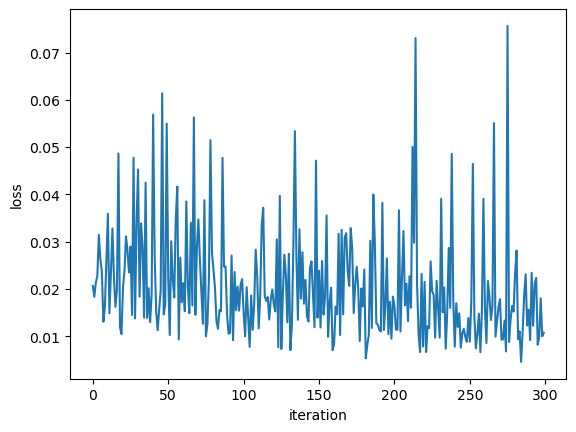

In [17]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


# Identifying misclassified samples


Identifying the first four misclassified samples using the validation data:


In [ ]:
model.eval()  # Set the model to evaluation mode
num_misclassified = 0
max_misclassified = 4  # Change this value to find more or fewer misclassified samples

for i, (x_test, y_test) in enumerate(validation_loader):
    with torch.no_grad():
        # Make predictions
        yhat = model(x_test)

        # Find the class with the maximum probability
        _, yhat = torch.max(yhat.data, 1)

        # Check for misclassified samples and print them
        for j in range(len(y_test)):
            if num_misclassified >= max_misclassified:
                break

            if yhat[j] != y_test[j]:
                print(f"Sample {i * validation_loader.batch_size + j} predicted value: {yhat[j]} actual value: {y_test[j]}")
                num_misclassified += 1

    if num_misclassified >= max_misclassified:
        break



Sample 66 predicted value: 0 actual value: 1
Sample 202 predicted value: 0 actual value: 1
Sample 426 predicted value: 0 actual value: 1
